In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


(4.0, 8.0)

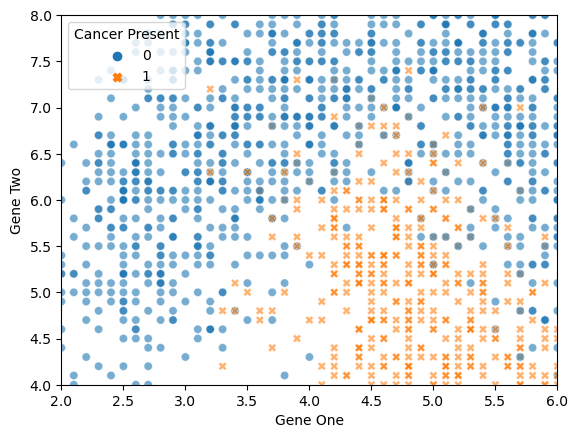

In [4]:
sns.scatterplot(data=df,x='Gene One',y='Gene Two',hue='Cancer Present'
                ,alpha=0.6,style='Cancer Present')
#To see where the overlapping of the classes occur so lets bring the range of
#X and Y down to hv a bettre look at the overlapping section
plt.xlim(2,6)
plt.ylim(4,8)

In [5]:
len(df)

3000

C:\Users\jagam\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


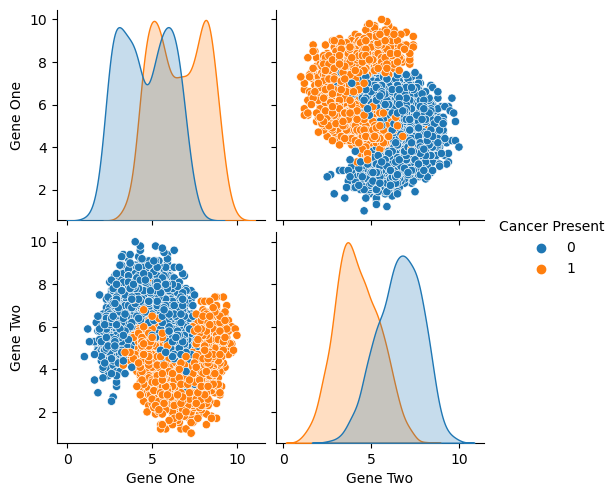

In [6]:
sns.pairplot(data=df,hue='Cancer Present')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
X = df.drop('Cancer Present',axis=1)

In [9]:
y = df['Cancer Present']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
scaler = StandardScaler()

In [12]:
scaled_X_train = scaler.fit_transform(X_train)

In [13]:
scaled_X_test = scaler.transform(X_test)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
#help(KNeighborsClassifier)

In [16]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [17]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [18]:
y_pred = knn_model.predict(scaled_X_test)

In [19]:
from sklearn.metrics import confusion_matrix,classification_report

In [20]:
confusion_matrix(y_test,y_pred)

array([[426,  44],
       [ 45, 385]], dtype=int64)

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



**Finding the value of K**

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_test,y_pred)

0.9011111111111111

In [24]:
# Error formula is 1-accuracy
1 - accuracy_score(y_test,y_pred)

0.09888888888888892

In [25]:
test_error_rate = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train)
    
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1-accuracy_score(y_test,y_pred_test)
    
    test_error_rate.append(test_error)

In [26]:
#test_error_rate

Text(0.5, 0, 'K Neighbors')

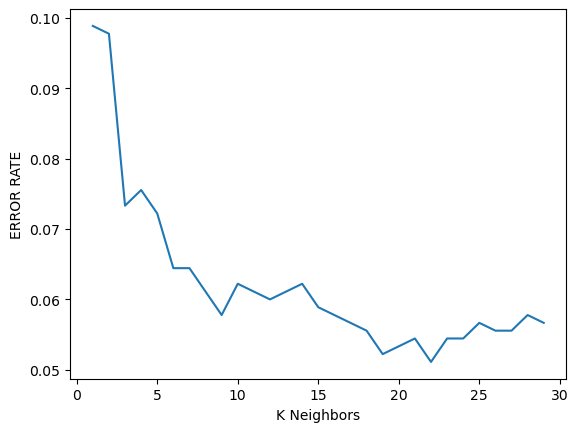

In [27]:
plt.plot(range(1,30),test_error_rate)
plt.ylabel('ERROR RATE')
plt.xlabel('K Neighbors')

**Grid Search using the PipeLine**

In [28]:
scaler = StandardScaler()

In [29]:
knn = KNeighborsClassifier()

In [30]:
operations = [('scaler',scaler),('knn',knn)]

In [31]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [32]:
from sklearn.pipeline import Pipeline

In [33]:
pipe = Pipeline(operations)

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
k_values = list(range(1,20))

In [36]:
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

### Creating a Pipeline to find K value

**Follow along very carefully here! We use very specific string codes AND variable names here so that everything matches up correctly. This is not a case where you can easily swap out variable names for whatever you want!**

We'll use a Pipeline object to set up a workflow of operations:

1. Scale Data
2. Create Model on Scaled Data

----
*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! [Full Info in Documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
* Step 1: the scaler is fitted on the TRAINING data
* Step 2: the scaler transforms TRAINING data
* Step 3: the models are fitted/trained using the transformed TRAINING data
* Step 4: the scaler is used to transform the TEST data
* Step 5: the trained models predict using the transformed TEST data

----

In [37]:
param_grid = {'knn__n_neighbors':k_values}

In [38]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring ='accuracy')

In [39]:
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [40]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [41]:
full_pred = full_cv_classifier.predict(X_test)

In [42]:
full_pred

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,

In [43]:
print(classification_report(y_test,full_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [44]:
new_patient = [[3.8,6.4]]

In [45]:
full_cv_classifier.predict(new_patient)

C:\Users\jagam\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [51]:
full_cv_classifier.predict_proba(new_patient)

C:\Users\jagam\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[1., 0.]])

In [46]:
full_cv_classifier.cv_results_

{'mean_fit_time': array([0.00358667, 0.00313911, 0.00442591, 0.0031425 , 0.00312452,
        0.        , 0.0031064 , 0.0062645 , 0.00209928, 0.0065352 ,
        0.00494733, 0.00301313, 0.0051075 , 0.00508018, 0.00314031,
        0.        , 0.00564003, 0.00375586, 0.00569935]),
 'std_fit_time': array([0.00608614, 0.00627823, 0.00613985, 0.006285  , 0.00624905,
        0.        , 0.00621281, 0.00767245, 0.00419855, 0.00523146,
        0.00498629, 0.00231043, 0.00656414, 0.00581864, 0.00628061,
        0.        , 0.00511515, 0.00538412, 0.00574562]),
 'mean_score_time': array([0.0165482 , 0.02396469, 0.01874757, 0.01875343, 0.01569915,
        0.01880555, 0.01876469, 0.01493845, 0.02113166, 0.01333666,
        0.02046633, 0.01899943, 0.01574769, 0.01692543, 0.01874771,
        0.02528949, 0.01530585, 0.01743584, 0.01871319]),
 'std_score_time': array([0.00127307, 0.00504315, 0.00624788, 0.0062471 , 0.00013693,
        0.00626508, 0.00623666, 0.00107955, 0.0063942 , 0.0072357 ,
        